In [1]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D,Flatten, Reshape, Dropout, BatchNormalization,LeakyReLU, Conv2DTranspose
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import optimizers
from keras import layers
import keras

In [2]:
buffer_size = 1000
batch_size = 256

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
discriminator = make_discriminator_model()

In [15]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [16]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [7]:
binary_crossentropy = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_out_put_for_gen_imgs):
    return binary_crossentropy(tf.ones_like(disc_out_put_for_gen_imgs), disc_out_put_for_gen_imgs)
# we want disc_out_put_for_gen_imgs all close to 1 which means discriminator think gen_imgs are true imges

def discriminator_loss(disc_out_put_for_true_imgs, disc_out_put_for_gen_imgs):
    disc_loss_for_true = binary_crossentropy(tf.zeros_like(disc_out_put_for_gen_imgs), disc_out_put_for_gen_imgs)
    disc_loss_for_gen = binary_crossentropy(tf.ones_like(disc_out_put_for_true_imgs), disc_out_put_for_true_imgs)
    return disc_loss_for_true+disc_loss_for_gen


generator_opt = optimizers.Adam(learning_rate=0.0001)
discriminator_opt = optimizers.Adam(learning_rate=0.0001)

In [8]:
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim, ])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_imgs = generator(noise, training = True)
        
        disc_out_put_for_true_imgs = discriminator(images, training = True)
        disc_out_put_for_gen_imgs = discriminator(gen_imgs, training = True)
        
        disc_loss = discriminator_loss(disc_out_put_for_true_imgs,disc_out_put_for_gen_imgs)
        gen_loss = generator_loss(disc_out_put_for_gen_imgs)
    gradient_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_opt.apply_gradients(zip(gradient_disc, discriminator.trainable_variables))
    
    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_opt.apply_gradients(zip(gradient_gen, generator.trainable_variables))

In [9]:
def generate_plot_image(gen_model, test_noise):
    pre_images = gen_model(test_noise, training = False)
    fig = plt.figure(figsize = (4,4))
    for i in range(pre_images.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((pre_images[i,:,:,0] +1)/2, cmap = 'gray')
        plt.axis('off')
    plt.show()

In [10]:
def train(ds, epochs):
    for epoch in range(epochs):
        for image_batch in ds:
            train_step(image_batch)
            print('.', end = '')
        generate_plot_image(generator, seed)
        print('Epoch:'+str(epoch))

In [11]:
### prameters
noise_dim = 100
num_exp_to_generate = 16
seed = tf.random.normal([num_exp_to_generate,noise_dim])

...........................................................................................................................................................................................................................................

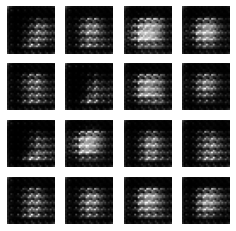

Epoch:0
...........................................................................................................................................................................................................................................

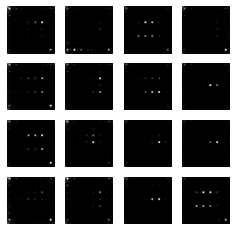

Epoch:1
...........................................................................................................................................................................................................................................

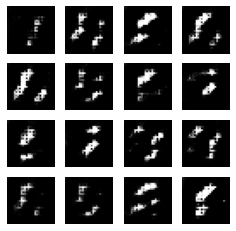

Epoch:2
...........................................................................................................................................................................................................................................

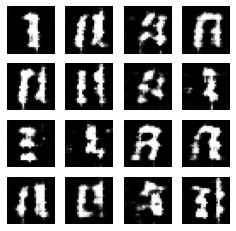

Epoch:3
...........................................................................................................................................................................................................................................

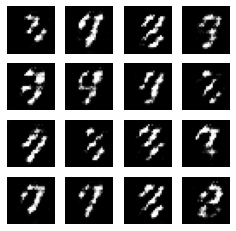

Epoch:4
...........................................................................................................................................................................................................................................

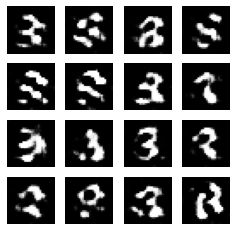

Epoch:5
...........................................................................................................................................................................................................................................

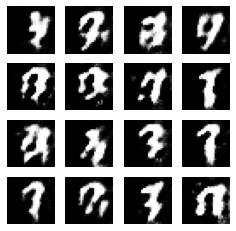

Epoch:6
...........................................................................................................................................................................................................................................

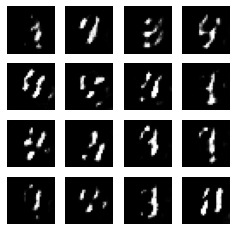

Epoch:7
...........................................................................................................................................................................................................................................

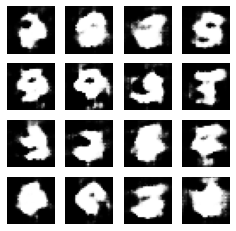

Epoch:8
...........................................................................................................................................................................................................................................

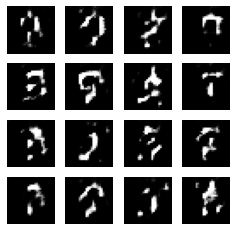

Epoch:9
...........................................................................................................................................................................................................................................

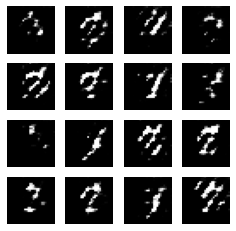

Epoch:10
...........................................................................................................................................................................................................................................

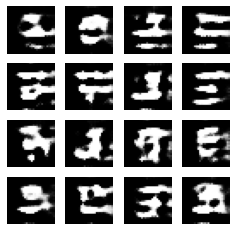

Epoch:11
...........................................................................................................................................................................................................................................

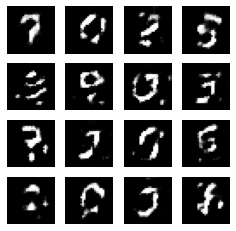

Epoch:12
...........................................................................................................................................................................................................................................

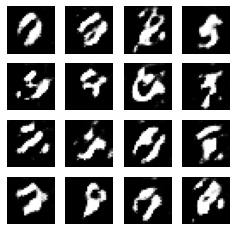

Epoch:13
...........................................................................................................................................................................................................................................

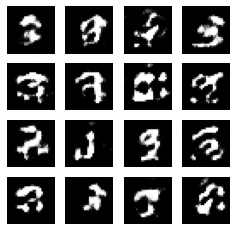

Epoch:14
...........................................................................................................................................................................................................................................

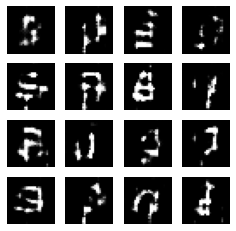

Epoch:15
...........................................................................................................................................................................................................................................

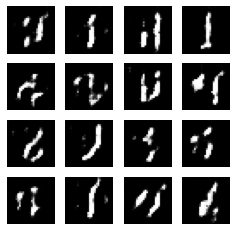

Epoch:16
...........................................................................................................................................................................................................................................

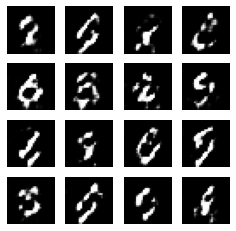

Epoch:17
...........................................................................................................................................................................................................................................

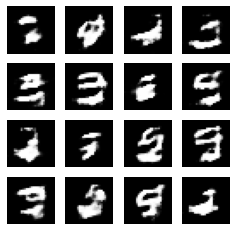

Epoch:18
...........................................................................................................................................................................................................................................

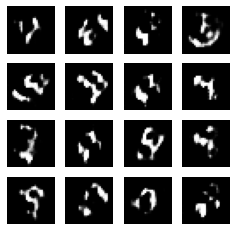

Epoch:19
...........................................................................................................................................................................................................................................

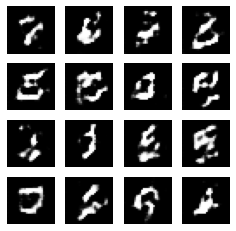

Epoch:20
...........................................................................................................................................................................................................................................

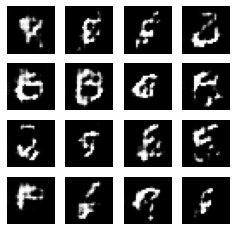

Epoch:21
...........................................................................................................................................................................................................................................

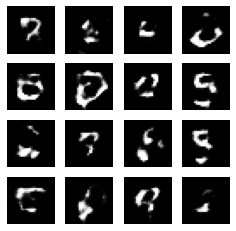

Epoch:22
...........................................................................................................................................................................................................................................

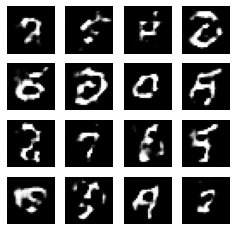

Epoch:23
...........................................................................................................................................................................................................................................

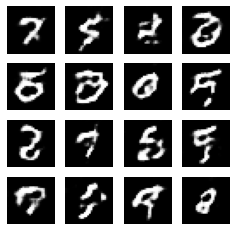

Epoch:24
...........................................................................................................................................................................................................................................

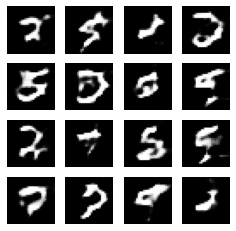

Epoch:25
...........................................................................................................................................................................................................................................

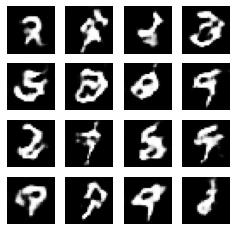

Epoch:26
...........................................................................................................................................................................................................................................

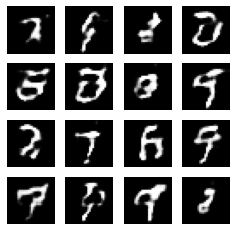

Epoch:27
...........................................................................................................................................................................................................................................

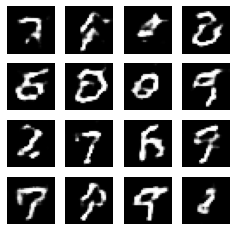

Epoch:28
...........................................................................................................................................................................................................................................

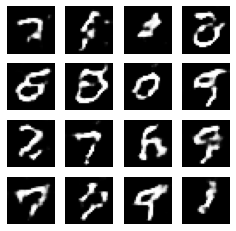

Epoch:29
...........................................................................................................................................................................................................................................

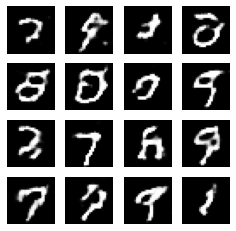

Epoch:30
...........................................................................................................................................................................................................................................

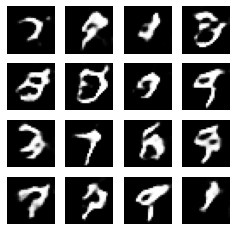

Epoch:31
...........................................................................................................................................................................................................................................

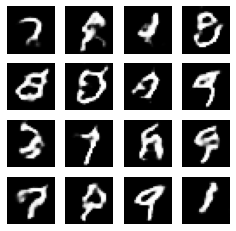

Epoch:32
...........................................................................................................................................................................................................................................

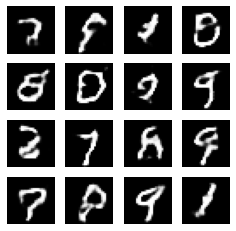

Epoch:33
...........................................................................................................................................................................................................................................

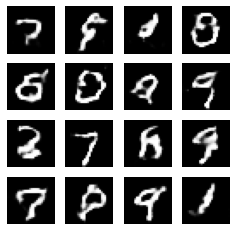

Epoch:34
...........................................................................................................................................................................................................................................

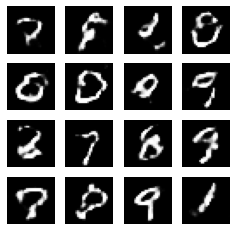

Epoch:35
...........................................................................................................................................................................................................................................

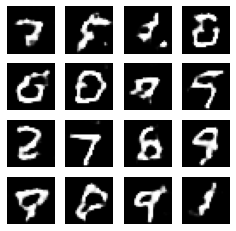

Epoch:36
...........................................................................................................................................................................................................................................

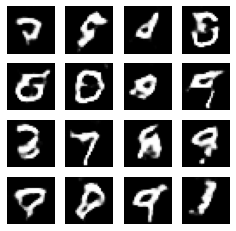

Epoch:37
...........................................................................................................................................................................................................................................

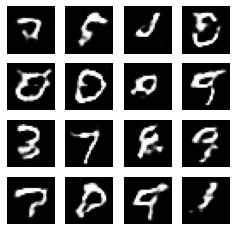

Epoch:38
...........................................................................................................................................................................................................................................

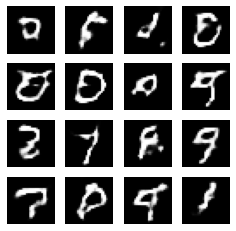

Epoch:39
...........................................................................................................................................................................................................................................

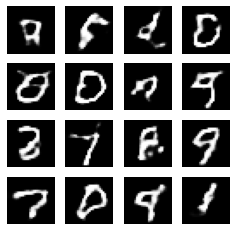

Epoch:40
...........................................................................................................................................................................................................................................

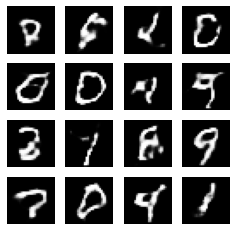

Epoch:41
...........................................................................................................................................................................................................................................

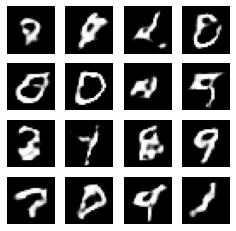

Epoch:42
...........................................................................................................................................................................................................................................

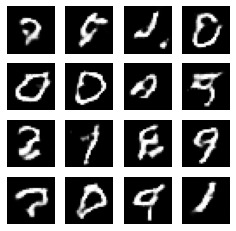

Epoch:43
...........................................................................................................................................................................................................................................

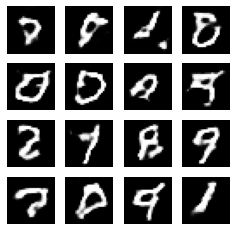

Epoch:44
...........................................................................................................................................................................................................................................

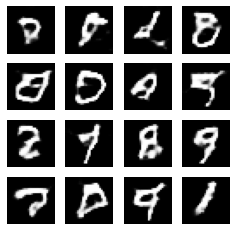

Epoch:45
...........................................................................................................................................................................................................................................

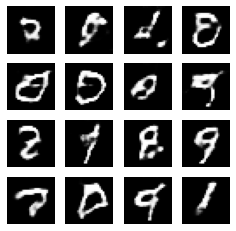

Epoch:46
...........................................................................................................................................................................................................................................

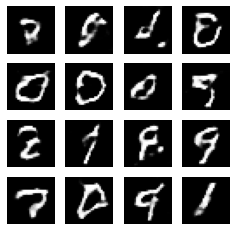

Epoch:47
...........................................................................................................................................................................................................................................

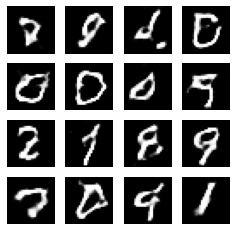

Epoch:48
...........................................................................................................................................................................................................................................

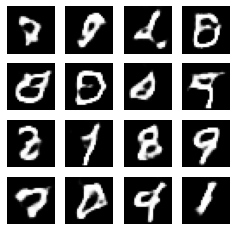

Epoch:49


In [12]:
epochs = 50
train(train_dataset, epochs)